<a href="https://colab.research.google.com/github/SandumiJay/Hybrid-CNN-LNN-Model/blob/09-09-2024/CNN_with_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#install required libraries
!pip install -r '/content/drive/MyDrive/requirements.txt'

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 38.1 MB/s eta 0:00:00
  Created wheel for httplib2shim: filename=httplib2shim-0.0.3-py2.py3-none-any.whl size=18041 sha256=ec5a5a2596d07282d8626459672c7295cf4b4389c73239a60b76b720b6564fdb
  Stored in directory: /root/.cache/pip/wheels/88/e5/dd/0096092515d7a3711c1bbc6c2ea1933a1fe1a62da93a6072a0
Successfully built httplib2shim


In [3]:
#import libraries
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import immutabledict

import tensorflow as tf
import numpy as np

from tqdm import tqdm
from typing import Callable, Tuple
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.losses_utils import reduce_weighted_loss

In [4]:
#Constants for the wildfire data export
INPUT_FEATURES = ('elevation', 'pdsi', 'NDVI', 'pr', 'sph', 'th', 'tmmn', 'tmmx', 'vs', 'erc', 'population', 'PrevFireMask')
OUTPUT_FEATURES = ('FireMask',)

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)

DATA_STATS = immutabledict.immutabledict({
    # 0.1 percentile, 99.9 percentile
    'elevation': (0., 3141., 657., 649.),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.1, 7.9, 0., 2.7),
    'NDVI': (-9821., 9996., 5158., 2467.),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.5, 1.7, 4.5),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0072, 0.0043),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.3, 72.6),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.2, 298.9, 281.1, 9.0),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.2, 315.1, 295.2, 9.8),
    # Wind velocity.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.0, 3.9, 1.4),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106., 37., 21.),
    # Population
    # min, 99.9 percentile
    'population': (0., 2534., 26., 155.),
    # We don't want to normalize the FireMasks.
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
})

In [5]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Randomly axis-align crop input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
        num_in_channels: number of channels in input_img.
        num_out_channels: number of channels in output_img.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    combined = tf.concat([input_img, output_img], axis=2)
    combined = tf.image.random_crop(
        combined,
        [sample_size, sample_size, num_in_channels + num_out_channels])
    input_img = combined[:, :, 0:num_in_channels]
    output_img = combined[:, :, -num_out_channels:]
    return input_img, output_img

def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Center crops input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    central_fraction = sample_size / input_img.shape[0]
    input_img = tf.image.central_crop(input_img, central_fraction)
    output_img = tf.image.central_crop(output_img, central_fraction)
    return input_img, output_img

# CNN Auto-encoder with all input features as a single image

In [6]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
    """Extracts the base key from the provided key.

    Earth Engine exports TFRecords containing each data variable with its
    corresponding variable name. In the case of time sequences, the name of the
    data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
    where 'variable' is the name of the variable, and n the number of elements
    in the time sequence. Extracting the base key ensures that each step of the
    time sequence goes through the same normalization steps.
    The base key obeys the following naming pattern: '([a-zA-Z]+)'
    For instance, for an input key 'variable_1', this function returns 'variable'.
    For an input key 'variable', this function simply returns 'variable'.

    Args:
        key: Input key.

    Returns:
        The corresponding base key.

    Raises:
        ValueError when `key` does not match the expected pattern.
    """
    match = re.match(r'([a-zA-Z]+)', key)
    if match:
        return match.group(1)

    raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))

def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and rescales inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and rescale.
        key: Key describing the inputs.

    Returns:
        Clipped and rescaled input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, _, _ = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))

def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and normalizes inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and normalize.
        key: Key describing the inputs.

    Returns:
        Clipped and normalized input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, mean, std = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    inputs = inputs - mean
    return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
    """Creates a features dictionary for TensorFlow IO.

    Args:
        sample_size: Size of the input tiles (square).
        features: List of feature names.

    Returns:
        A features dictionary for TensorFlow IO.
    """
    sample_shape = [sample_size, sample_size]
    features = set(features)
    columns = [
        tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
        for _ in features
    ]
    return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Reads a serialized example.

    Args:
        example_proto: A TensorFlow example protobuf.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        num_in_channels: Number of input channels.
        clip_and_normalize: True if the data should be clipped and normalized.
        clip_and_rescale: True if the data should be clipped and rescaled.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data should be cropped in the center.

    Returns:
        (input_img, output_img) tuple of inputs and outputs to the ML model.
    """
    if (random_crop and center_crop):
        raise ValueError('Cannot have both random_crop and center_crop be True')
    input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
    feature_names = input_features + output_features
    features_dict = _get_features_dict(data_size, feature_names)
    features = tf.io.parse_single_example(example_proto, features_dict)

    if clip_and_normalize:
        inputs_list = [
            _clip_and_normalize(features.get(key), key) for key in input_features
        ]
    elif clip_and_rescale:
        inputs_list = [
            _clip_and_rescale(features.get(key), key) for key in input_features
        ]
    else:
        inputs_list = [features.get(key) for key in input_features]

    inputs_stacked = tf.stack(inputs_list, axis=0)
    input_img = tf.transpose(inputs_stacked, [1, 2, 0])

    outputs_list = [features.get(key) for key in output_features]
    assert outputs_list, 'outputs_list should not be empty'
    outputs_stacked = tf.stack(outputs_list, axis=0)

    outputs_stacked_shape = outputs_stacked.get_shape().as_list()
    assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
    output_img = tf.transpose(outputs_stacked, [1, 2, 0])

    if random_crop:
        input_img, output_img = random_crop_input_and_output_images(
            input_img, output_img, sample_size, num_in_channels, 1)
    if center_crop:
        input_img, output_img = center_crop_input_and_output_images(
            input_img, output_img, sample_size)
    return input_img, output_img

def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
    """Gets the dataset from the file pattern.

    Args:
        file_pattern: Input file pattern.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        batch_size: Batch size.
        num_in_channels: Number of input channels.
        compression_type: Type of compression used for the input files.
        clip_and_normalize: True if the data should be clipped and normalized, False
          otherwise.
        clip_and_rescale: True if the data should be clipped and rescaled, False
          otherwise.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data shoulde be cropped in the center.

    Returns:
        A TensorFlow dataset loaded from the input file pattern, with features
        described in the constants, and with the shapes determined from the input
        parameters to this function.
    """
    if (clip_and_normalize and clip_and_rescale):
        raise ValueError('Cannot have both normalize and rescale.')
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(
        lambda x: _parse_fn(  # pylint: disable=g-long-lambda
            x, data_size, sample_size, num_in_channels, clip_and_normalize,
            clip_and_rescale, random_crop, center_crop),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [10]:
BATCH_SIZE = 32

train_dataset = get_dataset('/content/drive/MyDrive/wildfirex_datset/next_day_wildfire_spread_train*',
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

validation_dataset = get_dataset('/content/drive/MyDrive/wildfirex_datset/next_day_wildfire_spread_eval*',
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

test_dataset = get_dataset('/content/drive/MyDrive/wildfirex_datset/next_day_wildfire_spread_test*',
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=12, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

In [7]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]


In [8]:
def plot_samples_from_dataset(dataset: tf.data.Dataset, n_rows: int):
    """
    Plot 'n_rows' rows of samples from dataset.

    Args:
        dataset (Dataset): Dataset from which to plot samples.
        n_rows (int): Number of rows to plot.
    """
    global TITLES

    # Get batch
    inputs, labels = None, None
    for elem in dataset:
        inputs, labels = elem
        break

    fig = plt.figure(figsize=(15,6.5))

    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    # Number of data variables
    n_features = 12
    for i in range(n_rows):
        for j in range(n_features + 1):
            plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
            if i == 0:
                plt.title(TITLES[j], fontsize=13)
            if j < n_features - 1:
                plt.imshow(inputs[i, :, :, j], cmap='viridis')
            if j == n_features - 1:
                plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
            if j == n_features:
                plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)
            plt.axis('off')
    plt.tight_layout()

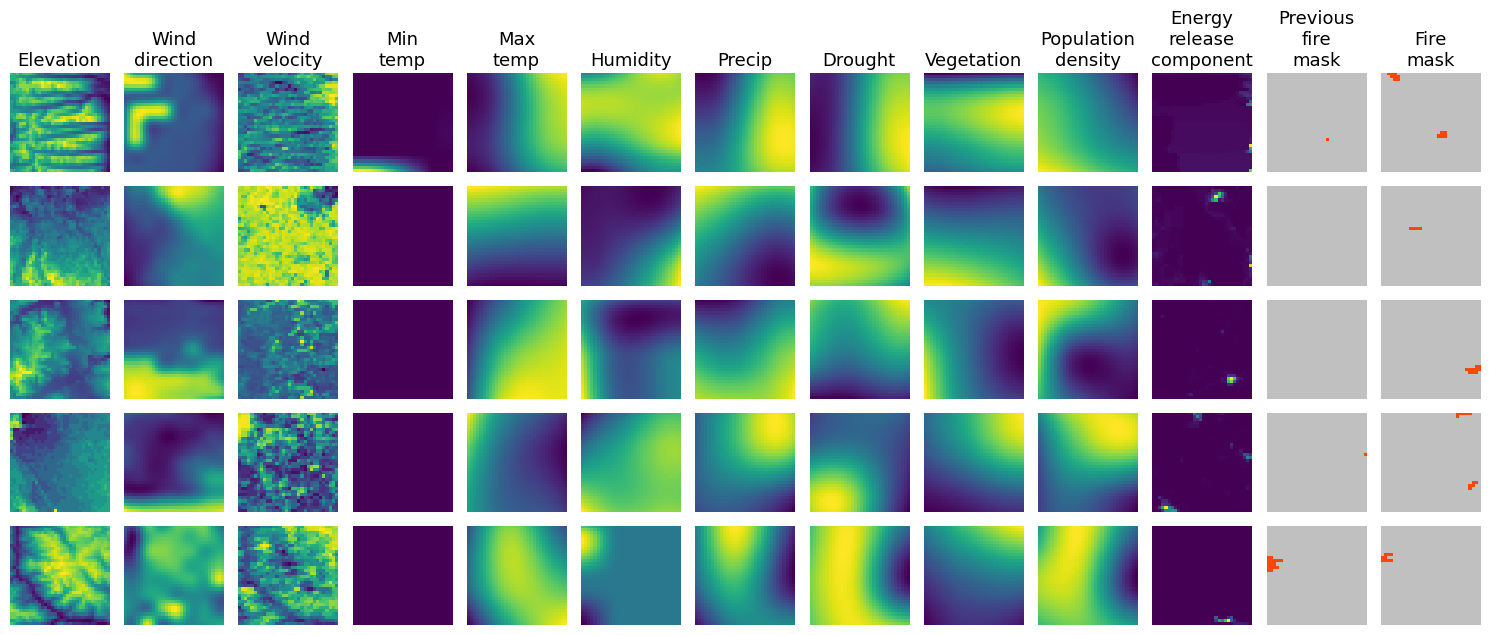

In [11]:
plot_samples_from_dataset(train_dataset, 5)

In [12]:
def IoU_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of intersection over union metric.

    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): IoU metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)

    intersection = np.logical_and(real_mask, predicted_mask)
    union = np.logical_or(real_mask, predicted_mask)

    if np.sum(union) == 0:
        return 1
    return np.sum(intersection) / np.sum(union)

def recall_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of recall metric.

    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): recall metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)

    true_positives = np.sum(np.logical_and(real_mask, predicted_mask))
    actual_positives = np.sum(real_mask)
    if actual_positives == 0:
        return 1

    return true_positives / actual_positives

def precision_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of precision metric.

    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): precision metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)

    true_positives = np.sum(np.logical_and(real_mask, predicted_mask))
    predicted_positives = np.sum(predicted_mask)
    if predicted_positives == 0:
        return 1

    return true_positives / predicted_positives

In [13]:
def dice_coef(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Dice loss function calculator.

    Args:
        y_true (Tensor):
        y_pred (Tensor):
    Returns:
        (Tensor): Dice loss for each element of a batch.
    """
    smooth = 1e-6
    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    intersection = K.sum(y_true_f * y_pred_f, axis=1)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f, axis=1) + K.sum(y_pred_f, axis=1) + smooth)

def weighted_bincrossentropy(true: tf.Tensor, pred: tf.Tensor, weight_zero: float = 0.01, weight_one: float = 1) -> float:
    """
    Calculates weighted binary cross entropy. The weights are fixed.

    This can be useful for unbalanced catagories.

    Adjust the weights here depending on what is required.

    For example if there are 10x as many positive classes as negative classes,
        if you adjust weight_zero = 1.0, weight_one = 0.1, then false positives
        will be penalize 10 times as much as false negatives.

    Args:
        true (Tensor): Ground-truth values
        pred (Tensor): Predited values
        weight_zero (float): Weight of class 0 (no-fire)
        weight_one (float): Weight of class 1 (fire)

    """

    # calculate the binary cross entropy
    bin_crossentropy = K.binary_crossentropy(true, pred)

    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy

    return K.mean(weighted_bin_crossentropy, axis=1)

def bce_dice_loss(y_true: tf.Tensor, y_pred: tf.Tensor):
    """
    BCE loss function calculator.

    Args:
        y_true (Tensor):
        y_pred (Tensor):
    Returns:
        (Tensor): Mean BCE Dice loss over a batch.
    """

    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    return reduce_weighted_loss(weighted_bincrossentropy(y_true_f, y_pred_f) + dice_coef(y_true, y_pred))

In [14]:
def evaluate_model(prediction_function: Callable[[tf.Tensor], tf.Tensor],
                   eval_dataset: tf.data.Dataset) -> Tuple[float, float, float, float]:
    """
    Loads dataset according to file pattern and evaluates model's predictions on it.

    Parameters:
        model (Callable[[tf.Tensor], tf.Tensor]): Function for model inference.
        eval_dataset (tf.dataDataset): Dataset for evaluation.

    Returns:
        Tuple[float, float, float, float]: IoU score, recall score, precision score and mean loss.
    """
    IoU_measures = []
    recall_measures = []
    precision_measures = []
    losses = []

    for inputs, labels in tqdm(eval_dataset):
        # Prediction shape (N, W, H)
        predictions = prediction_function(inputs)
        for i in range(inputs.shape[0]):
            IoU_measures.append(IoU_metric(labels[i, :, :,  0], predictions[i, :, :]))
            recall_measures.append(recall_metric(labels[i, :, :,  0], predictions[i, :, :]))
            precision_measures.append(precision_metric(labels[i, :, :,  0], predictions[i, :, :]))
        labels_cleared = tf.where(labels < 0, 0, labels)
        losses.append(bce_dice_loss(labels_cleared, tf.expand_dims(tf.cast(predictions, tf.float32), axis=-1)))

    mean_IoU = np.mean(IoU_measures)
    mean_recall = np.mean(recall_measures)
    mean_precision = np.mean(precision_measures)
    mean_loss = np.mean(losses)
    return mean_IoU, mean_recall, mean_precision, mean_loss

In [15]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-agxofrfm
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-agxofrfm
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=64ec3a069f08c16776feda0c4a6ba39c33b3dabafc4700c129532bad8936f185
  Stored in directory: /tmp/pip-ephem-wheel-cache-kjcmrs1u/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [16]:
from tensorflow_examples.models.pix2pix import pix2pix

def build_CNN_AE_model() -> Model:
    """
    Create CNN auto encode model.

    Returns:
        (Model): Keras model.
    """
    base_model = tf.keras.applications.MobileNetV2(input_shape=[32, 32, 12], include_top=False, weights=None)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 32x32
        'block_3_expand_relu',   # 16x16
        'block_6_expand_relu',   # 8x8
        'block_13_expand_relu',  # 4x4
        'block_16_project',      # 2x2
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = True

    up_stack = [
        pix2pix.upsample(512, 3),  # 2x2 -> 4x4
        pix2pix.upsample(256, 3),  # 4x4 -> 8x8
        pix2pix.upsample(128, 3),  # 8x8 -> 16x16
        pix2pix.upsample(64, 3),   # 16x16 -> 32x32
    ]

    inputs = tf.keras.layers.Input(shape=[32, 32, 12])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=2,
    padding='same')  #64x64 -> 128x128

    x = last(x)
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Create the segmentation model
segmentation_model = build_CNN_AE_model()
segmentation_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v2.py:210: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 12 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 12)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 16, 16, 96),   │      1,844,576 │ input_layer_1[0][0]    │
│                           │ (None, 8, 8, 144),     │                │                        │
│                           │ (None, 4, 4, 192),     │                │                        │
│                           │ (None, 2, 2, 576),     │                │                        │
│                           │ (None, 1, 1, 320)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 2, 2, 512)      │      1,476,608 │ functional[0][4]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2, 2, 1088)     │              0 │ sequential[0][0],      │
│                           │                        │                │ functional[0][3]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 4, 4, 256)      │      2,507,776 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 4, 4, 448)      │              0 │ sequential_1[0][0],    │
│ (Concatenate)             │                        │                │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 8, 8, 128)      │        516,608 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 8, 8, 272)      │              0 │ sequential_2[0][0],    │
│ (Concatenate)             │                        │                │ functional[0][1]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_3 (Sequential) │ (None, 16, 16, 64)     │        156,928 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 16, 16, 160)    │              0 │ sequential_3[0][0],    │
│ (Concatenate)             │                        │                │ functional[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 32, 32, 1)      │          1,441 │ concatenate_3[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 1)      │              2 │ conv2d_transpose_4[0]… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,503,939 (24.81 MB)

 Trainable params: 6,471,107 (24.69 MB)

 Non-trainable params: 32,832 (128.25 KB)

In [17]:
def train_model(model: Model, train_dataset: tf.data.Dataset, validation_dataset: tf.data.Dataset, epochs: int=10, patience: int=5) -> Tuple[List[float], List[float]]:
    """
    Trains a model using train dataset with early stopping based on IoU. (Save weights of model with best IoU)

    Args:
        model (Model): Model to train.
        train_dataset (Dataset): Training dataset.
        validation_dataset (Dataset): Validation dataset for IoU evaluation.
        epochs (int): Maximum number of epochs.
        patience (int): Number of epochs to wait for improvement before stopping.

    Returns:
        Tuple[List[float], List[float]]: Train losses and Validation losses
    """
    loss_fn = bce_dice_loss
    optimizer = tf.keras.optimizers.Adam()
    batch_losses = []
    val_losses = []
    best_IoU = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        if patience_counter >= patience:
            print(f"Stopping early at epoch {epoch} due to no improvement in IoU.")
            break

        losses = []
        print(f'Epoch {epoch+1}/{epochs}')
        # Iterate through the dataset
        progress = tqdm(train_dataset)
        for images, masks in progress:
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = model(images, training=True)
                label = tf.where(masks < 0, 0, masks)
                # Compute the loss
                loss = loss_fn(label, predictions)
                losses.append(loss.numpy())
                progress.set_postfix({'batch_loss': loss.numpy()})
            # Compute gradients
            gradients = tape.gradient(loss, model.trainable_variables)
            # Update the model's weights
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Evaluate model
        print("Evaluation...")
        IoU, recall, precision, val_loss = evaluate_model(lambda x: tf.where(model.predict(x) > 0.5, 1, 0)[:,:,:,0], validation_dataset)
        print("Validation set metrics:")
        print(f"Mean IoU: {IoU}\nMean precision: {precision}\nMean recall: {recall}\nValidation loss: {val_loss}\n")

        # Save best model based on IoU
        if IoU > best_IoU:
            best_IoU = IoU
            model.save_weights("best.weights.h5")
            patience_counter = 0  # Reset patience counter if we have improvement
        else:
            patience_counter += 1  # No improvement, increase patience counter

        # Print the loss for monitoring
        print(f'Epoch: {epoch}, Train loss: {np.mean(losses)}')
        batch_losses.append(np.mean(losses))
        val_losses.append(val_loss)

    print(f"Best model IoU: {best_IoU}")
    return batch_losses, val_losses

# Set reproducibility
tf.random.set_seed(1337)
segmentation_model = build_CNN_AE_model()

# Training with early stopping
train_losses, val_losses = train_model(segmentation_model, train_dataset, validation_dataset, epochs=50, patience=5)


Epoch 1/50


469it [10:21,  1.33s/it, batch_loss=0.974]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1it [00:08,  8.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


2it [00:08,  3.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


3it [00:08,  2.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


4it [00:08,  1.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


5it [00:09,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


6it [00:09,  1.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


7it [00:09,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


8it [00:09,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


9it [00:10,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


10it [00:10,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


11it [00:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


12it [00:10,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


13it [00:10,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


14it [00:11,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


15it [00:11,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


16it [00:12,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


17it [00:12,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


18it [00:13,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


19it [00:14,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


20it [00:14,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


21it [00:15,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


22it [00:15,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


23it [00:15,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


24it [00:16,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


25it [00:17,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


26it [00:18,  1.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


27it [00:18,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


28it [00:18,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


29it [00:18,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


30it [00:19,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


31it [00:19,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


32it [00:19,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


33it [00:20,  1.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


34it [00:20,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


35it [00:21,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


36it [00:21,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


37it [00:21,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


38it [00:21,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


39it [00:22,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


40it [00:22,  4.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


41it [00:22,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


42it [00:22,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


43it [00:23,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


44it [00:23,  4.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


45it [00:23,  3.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


46it [00:23,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


47it [00:24,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


48it [00:24,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


49it [00:24,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


50it [00:25,  3.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


51it [00:25,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


52it [00:25,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


53it [00:25,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


54it [00:26,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


55it [00:26,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


56it [00:26,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


57it [00:27,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


58it [00:27,  3.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


59it [00:41,  1.44it/s]


Validation set metrics:
Mean IoU: 0.14171550346297282
Mean precision: 1.0
Mean recall: 0.14171550346297282
Validation loss: 1.3053425550460815

Epoch: 0, Train loss: 0.8981785774230957
Epoch 2/50


469it [10:02,  1.28s/it, batch_loss=0.968]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


1it [00:00,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


2it [00:00,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


3it [00:00,  3.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


4it [00:01,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


5it [00:01,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


6it [00:01,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


7it [00:02,  3.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


8it [00:02,  3.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


9it [00:02,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


10it [00:02,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


11it [00:03,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


12it [00:03,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


13it [00:03,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


14it [00:03,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


15it [00:04,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


16it [00:04,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


17it [00:04,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


18it [00:04,  4.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


19it [00:04,  4.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


20it [00:05,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


21it [00:05,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


22it [00:05,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


23it [00:05,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


24it [00:06,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


25it [00:06,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


26it [00:06,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


27it [00:06,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


28it [00:06,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


29it [00:07,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


30it [00:07,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


31it [00:07,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


32it [00:07,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


33it [00:07,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


34it [00:08,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


35it [00:08,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


36it [00:08,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


37it [00:08,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


38it [00:08,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


39it [00:09,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


40it [00:09,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


41it [00:09,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


42it [00:09,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


43it [00:09,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


44it [00:10,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


45it [00:10,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


46it [00:10,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


47it [00:10,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


48it [00:10,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


49it [00:11,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


50it [00:11,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


51it [00:11,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


52it [00:11,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


53it [00:11,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


54it [00:12,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


55it [00:12,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


56it [00:12,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


57it [00:12,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


58it [00:12,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


59it [00:12,  4.58it/s]


Validation set metrics:
Mean IoU: 0.1390607081260215
Mean precision: 0.9989344698987747
Mean recall: 0.1390607081260215
Validation loss: 1.3175033330917358

Epoch: 1, Train loss: 0.8551608324050903
Epoch 3/50


469it [10:21,  1.33s/it, batch_loss=0.889]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


1it [00:00,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2it [00:00,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


3it [00:00,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


4it [00:00,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


5it [00:01,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


6it [00:01,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


7it [00:01,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


8it [00:01,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


9it [00:01,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


10it [00:02,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


11it [00:02,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


12it [00:02,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


13it [00:02,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


14it [00:02,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


15it [00:03,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


16it [00:03,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


17it [00:03,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


18it [00:03,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


19it [00:03,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


20it [00:04,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


21it [00:04,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


22it [00:04,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


23it [00:04,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


24it [00:04,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


25it [00:05,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


26it [00:05,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


27it [00:05,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


28it [00:05,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


29it [00:05,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


30it [00:06,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


31it [00:06,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


32it [00:06,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


33it [00:06,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


34it [00:06,  4.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


35it [00:07,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


36it [00:07,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


37it [00:07,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


38it [00:07,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


39it [00:08,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


40it [00:08,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


41it [00:08,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


42it [00:08,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


43it [00:09,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


44it [00:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


45it [00:09,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


46it [00:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


47it [00:10,  3.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


48it [00:10,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


49it [00:10,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


50it [00:11,  3.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


51it [00:11,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


52it [00:11,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


53it [00:11,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


54it [00:11,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


55it [00:12,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


56it [00:12,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


57it [00:12,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


58it [00:12,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


59it [00:20,  2.87it/s]


Validation set metrics:
Mean IoU: 0.1681185882173129
Mean precision: 0.8050162094281061
Mean recall: 0.1813704975422692
Validation loss: 1.2486640214920044

Epoch: 2, Train loss: 0.8519885540008545
Epoch 4/50


469it [09:59,  1.28s/it, batch_loss=0.973]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


1it [00:00,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2it [00:00,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


3it [00:01,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


4it [00:01,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


5it [00:01,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


6it [00:01,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


7it [00:02,  4.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


8it [00:02,  4.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


9it [00:02,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


10it [00:02,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


11it [00:02,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


12it [00:03,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


13it [00:03,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


14it [00:03,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


15it [00:03,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


16it [00:03,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


17it [00:04,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


18it [00:04,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


19it [00:04,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


20it [00:04,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


21it [00:04,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


22it [00:05,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


23it [00:05,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


24it [00:05,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


25it [00:05,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


26it [00:05,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


27it [00:06,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


28it [00:06,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


29it [00:06,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


30it [00:06,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


31it [00:06,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


32it [00:06,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


33it [00:07,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


34it [00:07,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


35it [00:07,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


36it [00:07,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


37it [00:07,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


38it [00:08,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


39it [00:08,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


40it [00:08,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


41it [00:08,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


42it [00:08,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


43it [00:09,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


44it [00:09,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


45it [00:09,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


46it [00:09,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


47it [00:09,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


48it [00:10,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


49it [00:10,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


50it [00:10,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


51it [00:10,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


52it [00:10,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


53it [00:11,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


54it [00:11,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


55it [00:11,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


56it [00:11,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


57it [00:12,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


58it [00:12,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


59it [00:12,  4.75it/s]


Validation set metrics:
Mean IoU: 0.19051154528546044
Mean precision: 0.7394134268493118
Mean recall: 0.2278933474156283
Validation loss: 1.1645766496658325

Epoch: 3, Train loss: 0.8455516695976257
Epoch 5/50


469it [09:48,  1.25s/it, batch_loss=0.868]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1it [00:00,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2it [00:00,  3.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


3it [00:00,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


4it [00:00,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


5it [00:01,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


6it [00:01,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


7it [00:01,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


8it [00:01,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


9it [00:01,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


10it [00:02,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


11it [00:02,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


12it [00:02,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


13it [00:02,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


14it [00:02,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


15it [00:03,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


16it [00:03,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


17it [00:03,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


18it [00:03,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


19it [00:03,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


20it [00:04,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


21it [00:04,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


22it [00:04,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


23it [00:04,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


24it [00:04,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


25it [00:05,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


26it [00:05,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


27it [00:05,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


28it [00:05,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


29it [00:05,  4.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


30it [00:06,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


31it [00:06,  4.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


32it [00:06,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


33it [00:06,  4.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


34it [00:07,  3.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


35it [00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


36it [00:07,  3.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


37it [00:07,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


38it [00:08,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


39it [00:08,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


40it [00:08,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


41it [00:08,  3.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


42it [00:09,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


43it [00:09,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


44it [00:09,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


45it [00:09,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


46it [00:10,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


47it [00:10,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


48it [00:10,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


49it [00:10,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


50it [00:10,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


51it [00:11,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


52it [00:11,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


53it [00:11,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


54it [00:11,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


55it [00:11,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


56it [00:11,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


57it [00:12,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


58it [00:12,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


59it [00:12,  4.74it/s]


Validation set metrics:
Mean IoU: 0.2139184063140948
Mean precision: 0.6353135525094219
Mean recall: 0.314009710423069
Validation loss: 1.0877089500427246

Epoch: 4, Train loss: 0.8441715240478516
Epoch 6/50


469it [10:21,  1.33s/it, batch_loss=0.945]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


1it [00:00,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


2it [00:00,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


3it [00:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


4it [00:01,  3.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


5it [00:01,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


6it [00:02,  3.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


7it [00:02,  3.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


8it [00:02,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


9it [00:02,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


10it [00:02,  4.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


11it [00:03,  4.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


12it [00:03,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


13it [00:03,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


14it [00:03,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


15it [00:03,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


16it [00:04,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


17it [00:04,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


18it [00:04,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


19it [00:04,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


20it [00:04,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


21it [00:05,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


22it [00:05,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


23it [00:05,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


24it [00:05,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


25it [00:05,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


26it [00:06,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


27it [00:06,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


28it [00:06,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


29it [00:06,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


30it [00:06,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


31it [00:07,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


32it [00:07,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


33it [00:07,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


34it [00:07,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


35it [00:07,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


36it [00:08,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


37it [00:08,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


38it [00:08,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


39it [00:08,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


40it [00:08,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


41it [00:09,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


42it [00:09,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


43it [00:09,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


44it [00:09,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


45it [00:09,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


46it [00:10,  4.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


47it [00:10,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


48it [00:10,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


49it [00:10,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


50it [00:10,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


51it [00:11,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


52it [00:11,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


53it [00:11,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


54it [00:11,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


55it [00:11,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


56it [00:12,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


57it [00:12,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


58it [00:12,  4.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


59it [00:12,  4.61it/s]

Validation set metrics:
Mean IoU: 0.2177355562714684
Mean precision: 0.5282035052089962
Mean recall: 0.40254517213016205
Validation loss: 1.049058198928833



Epoch: 5, Train loss: 0.8427726626396179
Epoch 7/50


469it [10:22,  1.33s/it, batch_loss=0.997]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


1it [00:00,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


2it [00:00,  3.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


3it [00:00,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


4it [00:01,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


5it [00:01,  4.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


6it [00:01,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


7it [00:01,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


8it [00:01,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


9it [00:01,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


10it [00:02,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


11it [00:02,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


12it [00:02,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


13it [00:02,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


14it [00:02,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


15it [00:03,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


16it [00:03,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


17it [00:03,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


18it [00:03,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


19it [00:03,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


20it [00:04,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


21it [00:04,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


22it [00:04,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


23it [00:04,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


24it [00:04,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


25it [00:05,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


26it [00:05,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


27it [00:05,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


28it [00:05,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


29it [00:06,  4.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


30it [00:06,  4.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


31it [00:06,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


32it [00:06,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


33it [00:07,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


34it [00:07,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


35it [00:07,  3.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


36it [00:07,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


37it [00:08,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


38it [00:08,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


39it [00:08,  3.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


40it [00:09,  3.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


41it [00:09,  3.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


42it [00:09,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


43it [00:09,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


44it [00:09,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


45it [00:10,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


46it [00:10,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


47it [00:10,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


48it [00:10,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


49it [00:10,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


50it [00:11,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


51it [00:11,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


52it [00:11,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


53it [00:11,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


54it [00:11,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


55it [00:11,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


56it [00:12,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


57it [00:12,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


58it [00:12,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


59it [00:12,  4.66it/s]


Validation set metrics:
Mean IoU: 0.22356951581079065
Mean precision: 0.4842776353929369
Mean recall: 0.4605833448699192
Validation loss: 0.9936995506286621

Epoch: 6, Train loss: 0.8403132557868958
Epoch 8/50


469it [10:21,  1.33s/it, batch_loss=0.883]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


1it [00:00,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2it [00:00,  3.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


3it [00:00,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


4it [00:00,  4.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


5it [00:01,  4.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


6it [00:01,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


7it [00:01,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


8it [00:01,  5.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


9it [00:01,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


10it [00:02,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


11it [00:02,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


12it [00:02,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


13it [00:02,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


14it [00:02,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


15it [00:03,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


16it [00:03,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


17it [00:03,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


18it [00:03,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


19it [00:03,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


20it [00:04,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


21it [00:04,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


22it [00:04,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


23it [00:04,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


24it [00:04,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


25it [00:04,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


26it [00:05,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


27it [00:05,  5.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


28it [00:05,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


29it [00:05,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


30it [00:05,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


31it [00:06,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


32it [00:06,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


33it [00:06,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


34it [00:06,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


35it [00:06,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


36it [00:07,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


37it [00:07,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


38it [00:07,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


39it [00:07,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


40it [00:07,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


41it [00:08,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


42it [00:08,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


43it [00:08,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


44it [00:08,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


45it [00:08,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


46it [00:09,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


47it [00:09,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


48it [00:09,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


49it [00:09,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


50it [00:10,  4.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


51it [00:10,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


52it [00:10,  3.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


53it [00:10,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


54it [00:11,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


55it [00:11,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


56it [00:11,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


57it [00:11,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


58it [00:12,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


59it [00:20,  2.87it/s]


Validation set metrics:
Mean IoU: 0.22025939201143663
Mean precision: 0.4541867750323766
Mean recall: 0.5160559671043327
Validation loss: 0.9687273502349854

Epoch: 7, Train loss: 0.837425708770752
Epoch 9/50


469it [10:21,  1.33s/it, batch_loss=0.975]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


1it [00:00,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


2it [00:00,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


3it [00:00,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


4it [00:01,  4.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


5it [00:01,  4.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


6it [00:01,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


7it [00:01,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


8it [00:01,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


9it [00:02,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


10it [00:02,  4.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


11it [00:02,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


12it [00:02,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


13it [00:02,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


14it [00:03,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


15it [00:03,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


16it [00:03,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


17it [00:03,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


18it [00:03,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


19it [00:04,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


20it [00:04,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


21it [00:04,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


22it [00:04,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


23it [00:04,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


24it [00:05,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


25it [00:05,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


26it [00:05,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


27it [00:05,  5.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


28it [00:05,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


29it [00:06,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


30it [00:06,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


31it [00:06,  4.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


32it [00:06,  4.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


33it [00:07,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


34it [00:07,  3.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


35it [00:07,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


36it [00:07,  3.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


37it [00:08,  3.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


38it [00:08,  3.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


39it [00:08,  3.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


40it [00:08,  3.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


41it [00:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


42it [00:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


43it [00:09,  3.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


44it [00:10,  3.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


45it [00:10,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


46it [00:10,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


47it [00:10,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


48it [00:10,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


49it [00:11,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


50it [00:11,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


51it [00:11,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


52it [00:11,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


53it [00:11,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


54it [00:12,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


55it [00:12,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


56it [00:12,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


57it [00:12,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


58it [00:12,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


59it [00:12,  4.58it/s]


Validation set metrics:
Mean IoU: 0.12743856902267825
Mean precision: 0.15878475844788376
Mean recall: 0.666958234699568
Validation loss: 1.0515657663345337

Epoch: 8, Train loss: 0.8357642889022827
Epoch 10/50


469it [10:21,  1.33s/it, batch_loss=1]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


1it [00:00,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


2it [00:00,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


3it [00:01,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


4it [00:01,  3.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


5it [00:01,  3.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


6it [00:01,  4.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


7it [00:01,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


8it [00:02,  4.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


9it [00:02,  4.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


10it [00:02,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


11it [00:02,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


12it [00:02,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


13it [00:03,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


14it [00:03,  5.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


15it [00:03,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


16it [00:03,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


17it [00:03,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


18it [00:04,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


19it [00:04,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


20it [00:04,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


21it [00:04,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


22it [00:04,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


23it [00:05,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


24it [00:05,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


25it [00:05,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


26it [00:05,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


27it [00:05,  5.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


28it [00:06,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


29it [00:06,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


30it [00:06,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


31it [00:06,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


32it [00:06,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


33it [00:07,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


34it [00:07,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


35it [00:07,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


36it [00:07,  5.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


37it [00:07,  5.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


38it [00:08,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


39it [00:08,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


40it [00:08,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


41it [00:08,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


42it [00:08,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


43it [00:09,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


44it [00:09,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


45it [00:09,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


46it [00:09,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


47it [00:09,  5.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


48it [00:10,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


49it [00:10,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


50it [00:10,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


51it [00:10,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


52it [00:10,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


53it [00:11,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


54it [00:11,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


55it [00:11,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


56it [00:11,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


57it [00:12,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


58it [00:12,  4.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


59it [00:12,  4.73it/s]


Validation set metrics:
Mean IoU: 0.13280128508789865
Mean precision: 0.16768727889918408
Mean recall: 0.6010765838704487
Validation loss: 1.045676350593567

Epoch: 9, Train loss: 0.8365699052810669
Epoch 11/50


469it [10:22,  1.33s/it, batch_loss=0.949]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1it [00:00,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


2it [00:00,  3.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


3it [00:00,  4.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


4it [00:01,  4.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


5it [00:01,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


6it [00:01,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


7it [00:01,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


8it [00:01,  4.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


9it [00:02,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


10it [00:02,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


11it [00:02,  4.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


12it [00:02,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


13it [00:02,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


14it [00:03,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


15it [00:03,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


16it [00:03,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


17it [00:03,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


18it [00:03,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


19it [00:04,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


20it [00:04,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


21it [00:04,  5.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


22it [00:04,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


23it [00:04,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


24it [00:05,  5.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


25it [00:05,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


26it [00:05,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


27it [00:05,  4.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


28it [00:05,  5.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


29it [00:06,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


30it [00:06,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


31it [00:06,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


32it [00:06,  4.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


33it [00:06,  5.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


34it [00:07,  5.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


35it [00:07,  5.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


36it [00:07,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


37it [00:07,  4.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


38it [00:07,  4.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


39it [00:08,  4.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


40it [00:08,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


41it [00:08,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


42it [00:09,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


43it [00:09,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


44it [00:09,  3.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


45it [00:09,  3.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


46it [00:10,  3.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


47it [00:10,  3.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


48it [00:10,  3.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


49it [00:11,  3.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


50it [00:11,  3.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


51it [00:11,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


52it [00:11,  4.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


53it [00:11,  4.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


54it [00:12,  4.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


55it [00:12,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


56it [00:12,  4.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


57it [00:12,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


58it [00:12,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


59it [00:12,  4.55it/s]


Validation set metrics:
Mean IoU: 0.13648698419774682
Mean precision: 0.16846424937971655
Mean recall: 0.6286874533952188
Validation loss: 1.0063822269439697

Epoch: 10, Train loss: 0.8369100093841553
Epoch 12/50


469it [09:50,  1.26s/it, batch_loss=1.25]


Evaluation...


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


1it [00:00,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


2it [00:00,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


3it [00:01,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


4it [00:01,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


5it [00:01,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


6it [00:02,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


7it [00:02,  3.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


8it [00:02,  3.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


9it [00:02,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


10it [00:02,  4.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


11it [00:03,  4.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


12it [00:03,  4.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


13it [00:03,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


14it [00:03,  4.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


15it [00:04,  4.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


16it [00:04,  4.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


17it [00:04,  4.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


18it [00:04,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


19it [00:04,  4.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


20it [00:05,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


21it [00:05,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


22it [00:05,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


23it [00:05,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


24it [00:05,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


25it [00:06,  4.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


26it [00:06,  4.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


27it [00:06,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


28it [00:06,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


29it [00:06,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


30it [00:07,  4.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


31it [00:07,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


32it [00:07,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


33it [00:07,  4.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


34it [00:07,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


35it [00:08,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


36it [00:08,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


37it [00:08,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


38it [00:08,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


39it [00:08,  4.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


40it [00:09,  4.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


41it [00:09,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


42it [00:09,  4.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


43it [00:09,  4.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


44it [00:10,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


45it [00:10,  4.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


46it [00:10,  4.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


47it [00:10,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


48it [00:10,  4.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


49it [00:11,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


50it [00:11,  4.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


51it [00:11,  4.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


52it [00:11,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


53it [00:11,  4.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


54it [00:12,  4.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


55it [00:12,  4.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


56it [00:12,  4.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


57it [00:12,  4.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


58it [00:13,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


59it [00:13,  4.38it/s]

Validation set metrics:
Mean IoU: 0.13646735617822014
Mean precision: 0.17663999388359475
Mean recall: 0.6032279021489863
Validation loss: 1.0359286069869995

Epoch: 11, Train loss: 0.8356379270553589
Stopping early at epoch 12 due to no improvement in IoU.
Best model IoU: 0.22356951581079065


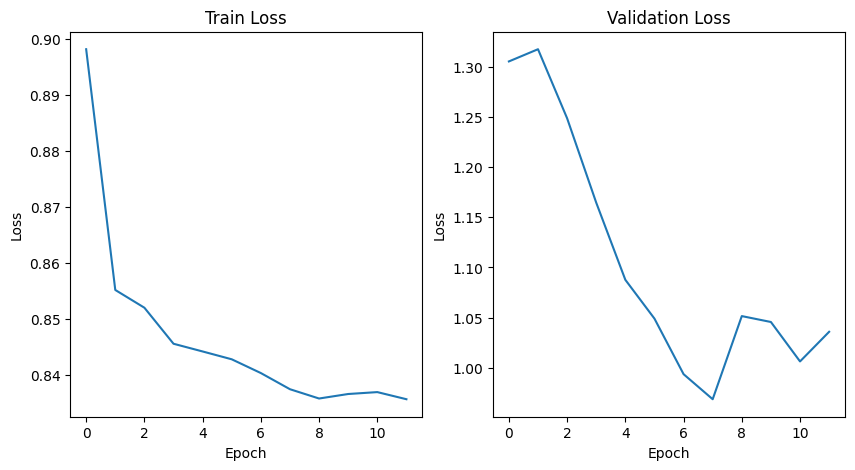

In [18]:
import matplotlib.pyplot as plt


def plot_train_and_val_losses(train_losses, val_losses):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(train_losses)
    axs[0].set_title("Train Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")

    axs[1].plot(val_losses)
    axs[1].set_title("Validation Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")

    plt.show()

# Plot the losses
plot_train_and_val_losses(train_losses, val_losses)


In [19]:
# Load best model
segmentation_model = build_CNN_AE_model()
segmentation_model.load_weights("best.weights.h5")

In [20]:
# Evaluate the model on the test dataset
iou, recall, precision, loss = evaluate_model(
    lambda x: tf.where(segmentation_model.predict(x) > 0.5, 1, 0)[:, :, :, 0], test_dataset
)

# Print the metrics
print("Test set metrics:")
print(f"Mean IoU: {iou}")
print(f"Mean precision: {precision}")
print(f"Mean recall: {recall}")
print(f"Mean loss: {loss}")


0it [00:00, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


1it [00:07,  7.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


2it [00:07,  3.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


3it [00:07,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


4it [00:08,  1.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


5it [00:08,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


6it [00:08,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


7it [00:08,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


8it [00:08,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


9it [00:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


10it [00:09,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


11it [00:09,  3.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


12it [00:09,  4.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


13it [00:10,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


14it [00:10,  4.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


15it [00:10,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


16it [00:10,  4.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


17it [00:10,  4.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


18it [00:11,  4.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


19it [00:11,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


20it [00:12,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


21it [00:12,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


22it [00:12,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


23it [00:13,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


24it [00:14,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


25it [00:14,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


26it [00:15,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


27it [00:15,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


28it [00:16,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


29it [00:16,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


30it [00:18,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


31it [00:19,  1.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


32it [00:19,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


33it [00:19,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


34it [00:19,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


35it [00:20,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


36it [00:20,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


37it [00:21,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


38it [00:21,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


39it [00:21,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


40it [00:22,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


41it [00:22,  3.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


42it [00:22,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


43it [00:22,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


44it [00:23,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


45it [00:23,  3.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


46it [00:23,  4.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


47it [00:23,  4.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


48it [00:23,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


49it [00:24,  5.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


50it [00:24,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


51it [00:24,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


52it [00:24,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


53it [00:28,  1.85it/s]

Test set metrics:
Mean IoU: 0.24932057850356684
Mean precision: 0.5105715946043133
Mean recall: 0.49357784557669215
Mean loss: 0.9118330478668213


In [21]:
from sklearn.metrics import classification_report

# Load the best weights
segmentation_model.load_weights("best.weights.h5")

# Make predictions on the test dataset
predictions = segmentation_model.predict(test_dataset)

# Convert probabilities to binary predictions (0 or 1)
binary_predictions = tf.where(predictions > 0.5, 1, 0)

# Flatten the predictions and labels
flat_predictions = binary_predictions.numpy().flatten()
flat_labels = np.concatenate([labels.numpy().flatten() for _, labels in test_dataset])

# Generate the classification report
report = classification_report(flat_labels, flat_predictions)

# Print the report
print(report)

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00     47785
         0.0       0.95      0.95      0.95   1635572
         1.0       0.06      0.10      0.08     46179

    accuracy                           0.91   1729536
   macro avg       0.34      0.35      0.34   1729536
weighted avg       0.90      0.91      0.90   1729536



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[      0   47279     506]
 [      0 1561182   74390]
 [      0   41383    4796]]


<Axes: >

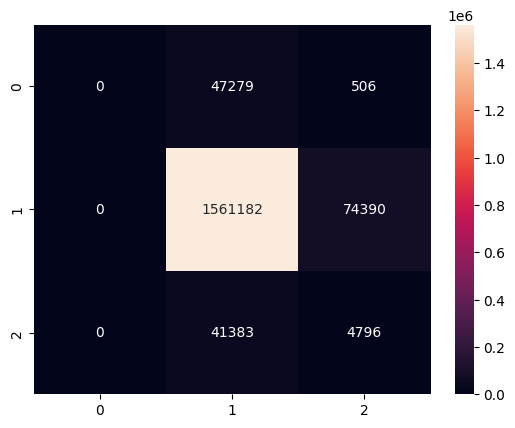

In [22]:
from sklearn.metrics import confusion_matrix

# ... (load best weights and generate binary_predictions as in previous response) ...

# Generate the confusion matrix
cm = confusion_matrix(flat_labels, flat_predictions)

# Print the confusion matrix
print(cm)

import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d")

In [23]:
def conv_layer_complexity(
    input_height: int,
    input_width: int,
    input_channels: int,
    output_channels: int,
    kernel_size: int,
) -> int:
    """Calculates the approximate complexity of a convolutional layer.

    Args:
        input_height: Height of the input feature map.
        input_width: Width of the input feature map.
        input_channels: Number of input channels.
        output_channels: Number of output channels.
        kernel_size: Size of the convolutional kernel.

    Returns:
        Approximate number of operations.
    """
    # Calculate the number of multiplications and additions per output element
    ops_per_output = kernel_size * kernel_size * input_channels

    # Calculate the number of output elements
    output_elements = input_height * input_width * output_channels

    # Total operations
    total_ops = ops_per_output * output_elements

    return total_ops

# Example usage
input_height = 32
input_width = 32
input_channels = 12
output_channels = 64
kernel_size = 3

complexity = conv_layer_complexity(
    input_height, input_width, input_channels, output_channels, kernel_size
)

print(f"Approximate complexity of the convolutional layer: {complexity} operations")

Approximate complexity of the convolutional layer: 7077888 operations


# CNN Auto-encoder with all input features as separate single images

In [14]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
    """Extracts the base key from the provided key.

    Earth Engine exports TFRecords containing each data variable with its
    corresponding variable name. In the case of time sequences, the name of the
    data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
    where 'variable' is the name of the variable, and n the number of elements
    in the time sequence. Extracting the base key ensures that each step of the
    time sequence goes through the same normalization steps.
    The base key obeys the following naming pattern: '([a-zA-Z]+)'
    For instance, for an input key 'variable_1', this function returns 'variable'.
    For an input key 'variable', this function simply returns 'variable'.

    Args:
        key: Input key.

    Returns:
        The corresponding base key.

    Raises:
        ValueError when `key` does not match the expected pattern.
    """
    match = re.match(r'([a-zA-Z]+)', key)
    if match:
        return match.group(1)

    raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))

def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and rescales inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and rescale.
        key: Key describing the inputs.

    Returns:
        Clipped and rescaled input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, _, _ = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))

def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and normalizes inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and normalize.
        key: Key describing the inputs.

    Returns:
        Clipped and normalized input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, mean, std = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    inputs = inputs - mean
    return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
    """Creates a features dictionary for TensorFlow IO.

    Args:
        sample_size: Size of the input tiles (square).
        features: List of feature names.

    Returns:
        A features dictionary for TensorFlow IO.
    """
    sample_shape = [sample_size, sample_size]
    features = set(features)
    columns = [
        tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
        for _ in features
    ]
    return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Reads a serialized example.

    Args:
        example_proto: A TensorFlow example protobuf.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        num_in_channels: Number of input channels.
        clip_and_normalize: True if the data should be clipped and normalized.
        clip_and_rescale: True if the data should be clipped and rescaled.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data should be cropped in the center.

    Returns:
        (input_img, output_img) tuple of inputs and outputs to the ML model.
    """
    if (random_crop and center_crop):
        raise ValueError('Cannot have both random_crop and center_crop be True')
    input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
    feature_names = input_features + output_features
    features_dict = _get_features_dict(data_size, feature_names)
    features = tf.io.parse_single_example(example_proto, features_dict)

    input_imgs = []
    if clip_and_normalize:
        for key in input_features:
            tensor = _clip_and_normalize(features.get(key), key)
            if random_crop:
                tensor = tf.image.random_crop(tensor, [sample_size, sample_size])
            if center_crop:
                tensor = tf.image.central_crop(tensor, central_fraction)
            input_imgs.append(tensor)
    elif clip_and_rescale:
        for key in input_features:
            tensor = _clip_and_rescale(features.get(key), key)
            if random_crop:
                tensor = tf.image.random_crop(tensor, [sample_size, sample_size])
            if center_crop:
                tensor = tf.image.central_crop(tensor, central_fraction)
            input_imgs.append(tensor)
    else:
        for key in input_features:
            tensor = features.get(key)
            if random_crop:
                tensor = tf.image.random_crop(tensor, [sample_size, sample_size])
            if center_crop:
                tensor = tf.image.central_crop(tensor, central_fraction)
            input_imgs.append(tensor)


    outputs_list = [features.get(key) for key in output_features]
    assert outputs_list, 'outputs_list should not be empty'
    outputs_stacked = tf.stack(outputs_list, axis=0)

    outputs_stacked_shape = outputs_stacked.get_shape().as_list()
    assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
    output_img = tf.transpose(outputs_stacked, [1, 2, 0])

    if random_crop:
        input_img, output_img = random_crop_input_and_output_images(
            input_img, output_img, sample_size, num_in_channels, 1)
    if center_crop:
        input_img, output_img = center_crop_input_and_output_images(
            input_img, output_img, sample_size)
    return input_img, output_img

def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
    """Gets the dataset from the file pattern.

    Args:
        file_pattern: Input file pattern.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        batch_size: Batch size.
        num_in_channels: Number of input channels.
        compression_type: Type of compression used for the input files.
        clip_and_normalize: True if the data should be clipped and normalized, False
          otherwise.
        clip_and_rescale: True if the data should be clipped and rescaled, False
          otherwise.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data shoulde be cropped in the center.

    Returns:
        A TensorFlow dataset loaded from the input file pattern, with features
        described in the constants, and with the shapes determined from the input
        parameters to this function.
    """
    if (clip_and_normalize and clip_and_rescale):
        raise ValueError('Cannot have both normalize and rescale.')
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(
        lambda x: _parse_fn(  # pylint: disable=g-long-lambda
            x, data_size, sample_size, num_in_channels, clip_and_normalize,
            clip_and_rescale, random_crop, center_crop),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [15]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

In [16]:
def plot_samples_from_dataset(dataset: tf.data.Dataset, n_rows: int):
    """
    Plot 'n_rows' rows of samples from dataset.

    Args:
        dataset (Dataset): Dataset from which to plot samples.
        n_rows (int): Number of rows to plot.
    """
    global TITLES

    # Get batch
    inputs, labels = None, None
    for elem in dataset:
        inputs, labels = elem
        break

    fig = plt.figure(figsize=(15,6.5))

    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    # Number of data variables
    n_features = 12
    for i in range(n_rows):
        for j in range(n_features + 1):
            plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
            if i == 0:
                plt.title(TITLES[j], fontsize=13)
            if j < n_features - 1:
                plt.imshow(inputs[i, :, :, j], cmap='viridis')
            if j == n_features - 1:
                plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
            if j == n_features:
                plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM)
            plt.axis('off')
    plt.tight_layout()

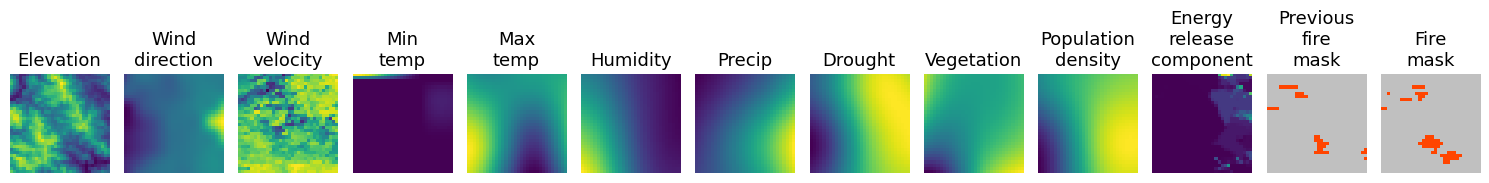

In [22]:
plot_samples_from_dataset(train_dataset, 1)

In [ ]:
# from tensorflow_examples.models.pix2pix import pix2pix

# def build_CNN_AE_model_ssi() -> Model:
#     """
#     Create CNN auto encode model.

#     Returns:
#         (Model): Keras model.
#     """
#     base_model  = [
#         tf.keras.layers.Input(shape=[32, 32, 1]) for _ in range(12)
#     ]

#     # Use the activations of these layers
#     layer_names = [
#         'block_1_expand_relu',   # 32x32
#         'block_3_expand_relu',   # 16x16
#         'block_6_expand_relu',   # 8x8
#         'block_13_expand_relu',  # 4x4
#         'block_16_project',      # 2x2
#     ]
#     base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

#     # Create the feature extraction model
#     down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

#     down_stack.trainable = True

#     up_stack = [
#         pix2pix.upsample(512, 3),  # 2x2 -> 4x4
#         pix2pix.upsample(256, 3),  # 4x4 -> 8x8
#         pix2pix.upsample(128, 3),  # 8x8 -> 16x16
#         pix2pix.upsample(64, 3),   # 16x16 -> 32x32
#     ]

#     inputs = [
#         tf.keras.layers.Input(shape=[32, 32, 1]) for _ in range(12)
#     ]

#     # Downsampling through the model
#     skips = down_stack(inputs)
#     x = skips[-1]
#     skips = reversed(skips[:-1])

#     # Upsampling and establishing the skip connections
#     for up, skip in zip(up_stack, skips):
#         x = up(x)
#         concat = tf.keras.layers.Concatenate()
#         x = concat([x, skip])

#     # This is the last layer of the model
#     last = tf.keras.layers.Conv2DTranspose(
#         filters=1, kernel_size=3, strides=2,
#     padding='same')  #64x64 -> 128x128

#     x = last(x)
#     outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(x)
#     return tf.keras.Model(inputs=inputs, outputs=outputs)

# # Create the segmentation model
# segmentation_model = build_CNN_AE_model_ssi()
# segmentation_model.summary()


In [18]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Input, Concatenate, Conv2DTranspose
from tensorflow_examples.models.pix2pix import pix2pix

def build_CNN_AE_model_ssi() -> Model:
    """
    Create CNN autoencoder model with separate channel inputs.

    Returns:
        (Model): Keras model.
    """

    inputs = [
        tf.keras.layers.Input(shape=[32, 32, 1]) for _ in range(12)
    ]

    # Process each channel individually (example with a shared set of layers)
    processed_inputs = []
    for input_tensor in inputs:
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
        # ... Add more layers as needed for your specific task ...
        processed_inputs.append(x)

    # Concatenate the processed channels
    merged = Concatenate()(processed_inputs)

    # Downsampling path
    x = Conv2D(128, (3, 3), activation='relu', strides=2, padding='same')(merged)
    x = Conv2D(256, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', strides=2, padding='same')(x)

    # Upsampling path
    x = Conv2DTranspose(256, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)

    # Output layer
    outputs = Conv2D(12, (3, 3), activation='sigmoid', padding='same')(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

# Create the segmentation model
segmentation_model = build_CNN_AE_model_ssi()
segmentation_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_4             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_6             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │            640 │ input_layer_1[0][0]    │
├──────────────────────

 Total params: 3,923,532 (14.97 MB)

 Trainable params: 3,923,532 (14.97 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def resize_images(images, target_shape):
    resized_images = []
    for image in images:
        resized_image = tf.image.resize(image, target_shape)
        resized_images.append(resized_image)
    return resized_images

In [ ]:
# def train_model(model, input_data, output_data, epochs, batch_size):
#   """Trains the model with separate channel inputs.

#   Args:
#     model: The Keras model to train.
#     input_data: List of 12 NumPy arrays, each representing a channel's training data.
#     output_data: NumPy array representing the target output data.
#     epochs: Number of training epochs.
#     batch_size: Batch size for training.
#   """

#   history = model.fit(
#       x=input_data,  # List of channel inputs
#       y=output_data,
#       epochs=epochs,
#       batch_size=batch_size,
#       # ... other parameters like validation data, callbacks, etc. ...
#   )
#   return history

# # --- Example usage ---
# # 1. Load and preprocess your data
# #    - Load your dataset (e.g., from files or a data generator)
# #    - Split the data into 12 separate channels (NumPy arrays)
# #    - Normalize or standardize the data as needed

# # Example: Assuming you have your data loaded into a NumPy array called 'data'
# #          where data.shape = (num_samples, 32, 32, 12)

# # Split the data into channels
# num_channels = 12
# input_data = [train_dataset[:, :, :, i] for i in range(num_channels)]

# # 2. Create the model
# segmentation_model = build_CNN_AE_model_ssi()

# # 3. Train the model
# history = train_model(
#     segmentation_model,
#     input_data,
#     data,  # Assuming you want to reconstruct the original data
#     epochs=10,
#     batch_size=32
# )

In [24]:
def train_model(model: Model, train_dataset: tf.data.Dataset, epochs:int=10) -> Tuple[List[float], List[float]]:
    """
    Trains a model using train dataset. (Save weights of model with best IoU)

    Args:
        model (Model): Model to train.
        train_dataset (Dataset): Training dataset.
        epochs (int): Number of epochs
    Returns:
        Tuple[List[float], List[float]]: Train losses and Validation losses
    """
    loss_fn = bce_dice_loss
    optimizer = tf.keras.optimizers.Adam()
    batch_losses = []
    val_losses = []
    best_IoU = 0.0

    for epoch in range(epochs):
        losses = []
        print(f'Epoch {epoch+1}/{epochs}')
        # Iterate through the dataset
        progress = tqdm(train_dataset)
        for data in progress:
            input_imgs = [data[:,:,:,i] for i in range(num_channels)] # Extracting individual channel data
            masks = data # Assuming masks are included in the dataset
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = model(input_imgs, training=True)
                label = tf.where(masks < 0, 0, masks)
                label = tf.cast(label, dtype=tf.float32)
                # Compute the loss
                loss = loss_fn(label, predictions)
                losses.append(loss.numpy())
                progress.set_postfix({'batch_loss': loss.numpy()})
            # Compute gradients
            gradients = tape.gradient(loss, model.trainable_variables)
            # Update the model's weights
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # Evaluate model
        print("Evaluation...")
        IoU, recall, precision, val_loss = evaluate_model(lambda x: tf.where(model.predict(x) > 0.5, 1, 0)[:,:,:,0], validation_dataset)
        print("Validation set metrics:")
        print(f"Mean IoU: {IoU}\nMean precision: {precision}\nMean recall: {recall}\nValidation loss: {val_loss}\n")
        # Save best model
        if IoU > best_IoU:
            best_IoU = IoU
            model.save_weights("best_ssi.weights.h5")

        # Print the loss for monitoring
        print(f'Epoch: {epoch}, Train loss: {np.mean(losses)}')
        batch_losses.append(np.mean(losses))
        val_losses.append(val_loss)

    print(f"Best model IoU: {best_IoU}")
    return batch_losses, val_losses

# Set reproducability
tf.random.set_seed(1337)

num_channels = 12
# Convert the dataset to a NumPy array to enable slicing
train_dataset_np = list(train_dataset.as_numpy_iterator())

# Set reproducability
tf.random.set_seed(1337)

num_channels = 12
# Convert the dataset to a NumPy array to enable slicing
train_dataset_np = list(train_dataset.as_numpy_iterator())

# Check shapes and ensure consistency
shapes = [item[0].shape for item in train_dataset_np]

# Identify and remove inconsistent shapes
consistent_indices = [i for i, shape in enumerate(shapes) if shape == shapes[0]]
train_dataset_np = [train_dataset_np[i] for i in consistent_indices]
shapes = [item[0].shape for item in train_dataset_np]

# Check if all shapes are equal to the first shape (after removing inconsistencies)
if all(shape == shapes[0] for shape in shapes):
    input_data = [np.array([item[0][:, :, :, i] for item in train_dataset_np]) for i in range(num_channels)]
else:
    print("Error: Inconsistent shapes still present after filtering.")

segmentation_model = build_CNN_AE_model_ssi()
train_losses, val_losses = train_model(segmentation_model, input_data, epochs=15) # This line is commented out to avoid using undefined variables.

Epoch 1/15


  0%|          | 0/12 [00:00<?, ?it/s]


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:Mul] name: 